# Comparing Pspec and Manually Calculated Power Values
In this notebook, it is possible to supply random gaussian data to pspec and compare with real data. Moreover, there is also the choice to use Pspec or to directly calculate the power spectrum. Thus, many comparisons can be made comparing Gaussian Pspec data to real Pspec data or real direct data to Pspec data, etc.

In [2]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
import scipy
import matplotlib.gridspec as gspec
from scipy.optimize import curve_fit
import math
from matplotlib.ticker import MaxNLocator

In [3]:
def Plot_Results(pspec_data,second_data,pspec_label,second_data_label):
    #Unpack the results
    delay_quantity = pspec_data[2]
    stan_dev_pspec = np.array(pspec_data[1])
    mean_pspec = np.array(pspec_data[0])
    # We must properly order the spw ranges associated with the correct y values
    x_axis_label_type = pspec_data[3]
    
    baseline = pspec_data[4]
    
    second_mean = np.array(second_data[0])
    second_stan_dev = np.array(second_data[1])
    second_quantity = second_data[2]

    fig = plt.figure(figsize=(14,8))
    gs = gspec.GridSpec(2, 2)
    
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[0, 1])
    ax4 = plt.subplot(gs[1, 1])
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    
    # We plot the standard deviation of both the real data and the generated Gaussian data sharing the same axis.
    ax1_twin = ax1.twinx()
    
    lns1 = ax1.plot(x_axis_label_type,stan_dev_pspec,color='blue',lw=7)
    lns2 = ax1_twin.plot(x_axis_label_type,second_stan_dev,color='red',lw=3)
    #ax1.plot(stan_dev_pspec,color='blue',alpha=0.2)
    #ax1_twin.plot(second_stan_dev,color='red',alpha=0.2)
    # This section is tweaks regarding the x axis labelled values and the legend figure.
    #ax1_twin.set_yticklabels([])
    
    ax1.xaxis.set_major_locator(MaxNLocator(3))
    ax1_twin.xaxis.set_major_locator(MaxNLocator(3))
    
    ax1.xaxis.grid(True)
    ax1.yaxis.grid(True)
    ax1.set_ylabel("Residual Standard deviation",fontsize=14)
    ax1.set_xlabel("Frequency range (MHz)",fontsize=14)
    ax1.set_title("full spw : ("+str(fmin)+","+str(fmax)+"), bls = {0}".format((baseline,baseline)),fontsize=14)
    
    
    # We then plot the average power with error bars of the Gaussian generated noise.
    #mean_order = magnitude(mean_pspec[0])
    #std_order = magnitude(stan_dev_pspec[0])
    
    ax2.xaxis.set_major_locator(MaxNLocator(3))
    ax2.plot(x_axis_label_type,mean_pspec,color='blue',label=pspec_label,lw=3)
    ax2.errorbar(x_axis_label_type,mean_pspec,yerr=stan_dev_pspec, linestyle="None",capsize=4,elinewidth=1,ecolor='k')
    
    ax2.xaxis.grid(True)
    ax2.yaxis.grid(True)
    ax2.set_ylabel("Residual Average P(k)",fontsize=14)
    ax2.set_xlabel("Frequency range (MHz)",fontsize=14)
    ax2.legend(loc='best',prop={'size': 14})
    # We then plot the average power of the real power with error bars.
    #mean_order = magnitude(second_mean[0])
    #std_order = magnitude(second_stan_dev[0])
    
    ax3.plot(x_axis_label_type,second_mean,color='red',label=second_data_label,lw=3)
    ax3.errorbar(x_axis_label_type,second_mean,yerr=second_stan_dev, linestyle="None",capsize=4,elinewidth=1,ecolor='k')
    ax3.xaxis.set_major_locator(MaxNLocator(3))
    ax3.xaxis.grid(True)
    ax3.yaxis.grid(True)
    ax3.set_ylabel("Residual Average P(k)",fontsize=14)
    ax3.set_xlabel("Frequency range (MHz)",fontsize=14)
    ax3.legend(loc='best',prop={'size': 14})  
    # Lastly we plot the number of x axis data points we used  as a function of the spw range.
    ax4.plot(x_axis_label_type,delay_quantity,color='g',lw=3)
    ax4.xaxis.set_major_locator(MaxNLocator(3))
    ax4.xaxis.grid(True)
    ax4.yaxis.grid(True)
    ax4.set_xlabel("Frequency range",fontsize=14)
    ax4.set_ylabel("Number of delay data points",fontsize=14)
    

    #ax1_twin.set_yticklabels([])
    plt.tight_layout()

In [4]:
def Simulated_Gaussian_Noise(sigma,mu):
    
    for time in range(0,60):
        if time == 0:
            visibility_data = np.random.normal(mu,sigma,1024)
        else:
            noise = np.random.normal(mu,sigma,1024)
        if time != 0:
            visibility_data = np.vstack((visibility_data,noise))
    
    return visibility_data

In [13]:
def Pspec_Data(baseline,fmin,n_dly,data_quantity,pol,exct_n):
    
    # Set up the key for the power spectrum data
    key=(0,(baseline,baseline),pol)

    median_power = []
    stan_dev_power = []
    spw_range = []
    delay_quantity = []
    mean_power=[]
    mean_null_power = []
    stan_dev_null_power = []
    median_null_power = []
    MAD = []
    #num_delays = np.min(data_quantity)
    # The -2 is there to avoid generating power spectrums where the spw range is too small.
    for num in data_quantity:
        
        
        uvp = ds.pspec([baseline], [baseline], (0, 1), [(pol, pol)],spw_ranges=[(fmin,fmin+num)],exact_norm=exct_n,n_dlys = None,norm = 'I',input_data_weight='identity', taper='none', verbose=False)
        
        # We calculate the size of the spectral window depending on the number of iterations
        n_dly=num
        power = np.abs(np.real(uvp.get_data(key))).T
        avg_power_delay = np.mean(power[int(2*(n_dly)/3):int(n_dly),:],axis=0)
        
        #odd_time_power = power[int(2*(spw_size)/3):int(spw_size),:power.shape[1]//2]
        #even_time_power = power[int(2*(spw_size)/3):int(spw_size),power.shape[1]//2:]
        odd_time_power = power[int(2*(n_dly)/3):int(n_dly),::2]
        even_time_power = power[int(2*(n_dly)/3):int(n_dly),1::2]
        #null_power = np.subtract(odd_time_power[:,:-1],even_time_power)
        null_power = np.subtract(odd_time_power[:,:],even_time_power)
        average_null_power = np.mean(null_power,axis=0)
        
        mean_null_power.append(np.mean(average_null_power))
        median_null_power.append(np.median(average_null_power))
        stan_dev_null_power.append(np.std(average_null_power))
        
        median_power.append(np.median(avg_power_delay))
        MAD.append(np.median(np.abs(avg_power_delay-np.median(avg_power_delay))))
        mean_power.append(np.mean(avg_power_delay))
        stan_dev_power.append(np.std(avg_power_delay))
        spw_range.append('('+str(int(uvd.freq_array[0,fmin]/1e4)/100)+'-'+str(int(uvd.freq_array[0,fmin+num]/1e4)/100)+')')
        delay_quantity.append(int(n_dly)-int(2*(n_dly)/3))
    # We return the data as a list containings lists.
    return [mean_power,stan_dev_power,delay_quantity,spw_range,baseline,median_power,MAD],[mean_null_power,stan_dev_null_power,delay_quantity,spw_range,baseline,median_null_power,MAD]

In [15]:
def Direct_Data(fmin,fmax,vis_data,data_quantity):

    std = []
    mean = []

    delay_data= np.fft.fftshift(np.fft.fft(np.fft.fftshift(vis_data,axes=1),axis=1),axes=1)
    
    for num in data_quantity:
        
        k = np.trapz(uvb.power_beam_sq_int('XX')/(uvb.power_beam_int('XX')**2),uvb.beam_freqs)/((num*(uvb.beam_freqs[1]-uvb.beam_freqs[0]))**2)
        #delay_real = np.fft.fftshift(np.fft.fft(np.fft.fftshift(real_data[:,fmin:fmin+num],axes=1),axis=1),axes=1)
        odd_v = delay_data[::2,:]
        even_v = delay_data[1::2,:]

        if odd_v.shape[0] != even_v.shape[0]:
            print(odd_v.shape[0],even_v.shape[0])
            if odd_v.shape[0] > even_v.shape[0]:
                odd_v = odd_v[0:-1,:]
            else:
                even_v = even_v[0:-1,:]
        power = np.abs(even_v[:,int(2*num/3):num])*np.abs(odd_v[:,int(2*num/3):num])/(k*num**2)

        std.append(np.std(np.mean(power,axis=1)))
        mean.append(np.mean(np.mean(power,axis=1)))
    return [mean,std,data_quantity]

In [7]:
# select the data file to load
#dfile = os.path.join(DATA_PATH, 'eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5')
dfile = os.path.join(DATA_PATH, 'zen.2458116.38650.xx.HH.uvOCRS')
# Load into UVData objects
uvd = UVData()
uvd.read(dfile)

In [8]:
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
#beam_freqs = np.linspace(0, 384e6, 384)
#uvb = hp.PSpecBeamGauss(fwhm=0.2117, beam_freqs=beam_freqs)

In [9]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

In [10]:
fmin = 520
fmax =690
spw_jumps = 5

baseline = (1,121)
# Baseline_gaussian will be the baseline in which we store gaussian data so that we can use this baseline in pspec
baseline_gaussian = (24,25)
pol = 'xx'

# Generate gaussian data and store it in one of the baseline's data in uvd.data_array
sigma=10
mu=10
key=(baseline_gaussian[0],baseline_gaussian[1],pol)
ind1,ind2,indp = uvd._key2inds(key)
uvd.data_array[ind1,0,:,0] = Simulated_Gaussian_Noise(sigma,mu)

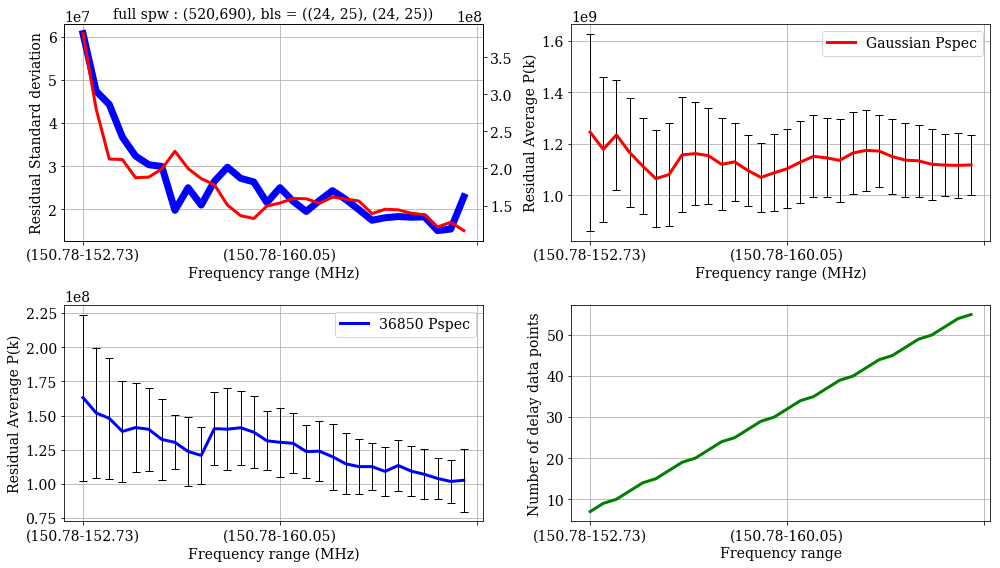

In [16]:
#for n_dly in n_range:
vis_data = uvd.get_data((24,25,pol))

data_quantity = np.arange(40,fmax-fmin,spw_jumps)
exact_norm = True
n_dly=None
#pspec_data, null_pspec_data = Pspec_Data(baseline,fmin,n_dly,data_quantity,pol)
gaussian_pspec, null_gaussian_pspec = Pspec_Data(baseline_gaussian,fmin,n_dly,data_quantity,pol,exact_norm)
direct_data = Direct_Data(fmin,fmax,vis_data,data_quantity)

# It is possible to store results from each plot for another purpose
# pspec_std.append(np.std(pspec_data[1])/np.mean(pspec_data[0]))
# pspec_mean.append(np.mean(pspec_data[1])/np.mean(pspec_data[0]))
# second_std.append(np.std(gaussian_pspec[1])/np.mean(gaussian_pspec[0]))
# second_mean.append(np.mean(gaussian_pspec[1])/np.mean(gaussian_pspec[0]))
# num_delays.append(n_dly)
#Plot_Results(pspec_data,direct_data) 

# The data is stored in a list so that it is possible to plot the residuals between the true normalization
# and the approximation
if exact_norm == True:
    True_norm.append([pspec_data,gaussian_data])
else:
    False_norm.append([pspec_data,gaussian_data])
    
Plot_Results(gaussian_pspec,direct_data,'36850 Pspec','Gaussian Pspec')
#plt.savefig("36850_Pspec-Gaussian_pspec-(520,690)-fmin+num=540-(1,121)-taper=none-n_dlys=none-exact_norm=True.pdf")

In [39]:
res_pspec = [np.array(True_norm[0][0])-np.array(False_norm[0][0]),np.array(True_norm[0][1])-np.array(False_norm[0][1]),True_norm[0][2],True_norm[0][3],True_norm[0][4],True_norm[0][5],True_norm[0][6]]
res_gaussian = [np.array(True_norm[1][0])-np.array(False_norm[1][0]),np.array(True_norm[1][1])-np.array(False_norm[1][1]),True_norm[0][2],True_norm[0][3],True_norm[0][4],True_norm[0][5],True_norm[0][6]]

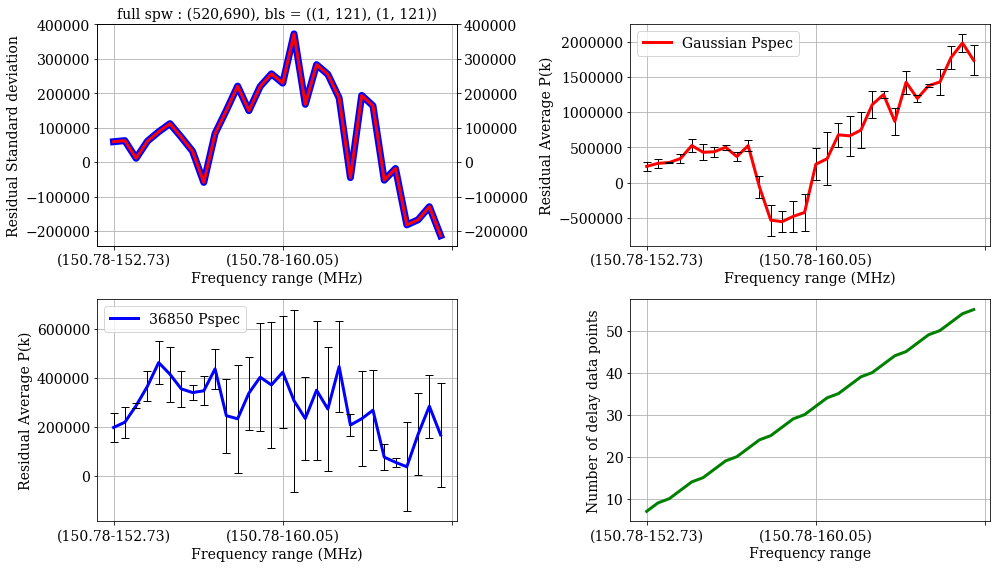

In [50]:
Plot_Results(res_pspec,res_gaussian,'36850 Pspec','Gaussian Pspec')
plt.savefig("Residuals_exact_norm_True_vs_False-36850_Pspec-Gaussian_pspec-(520,690)-fmin+num=540-(1,121)-taper=none-n_dlys=none.pdf")

The user can make a plot of the standard deviation of the standard deviation by repeating and stocking results
for different constant number of delay bins.

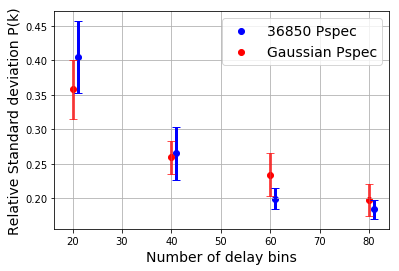

In [20]:
plt.scatter(np.array(num_delays)+1,pspec_mean,label='36850 Pspec',color='b')
plt.scatter(num_delays,second_mean,label='Gaussian Pspec',color='r')
plt.errorbar(np.array(num_delays)+1,pspec_mean,yerr=pspec_std, linestyle="None",capsize=4,elinewidth=3,ecolor='b')
plt.errorbar(num_delays,second_mean,yerr=second_std, linestyle="None",capsize=4,elinewidth=3,ecolor='r',alpha=0.7)
plt.grid()
plt.ylabel("Relative Standard deviation P(k)",fontsize=14)
plt.xlabel("Number of delay bins",fontsize=14)
plt.legend(prop={'size': 14})
#plt.savefig("std vs delay bins 4 constant freq range (100-170 bins, 520-690)-exact_norm=False.pdf")
plt.show()